# Experiment Template


**In this notebook:**

* Load original mri data + vessel mask
* Resample Images to 1.5 mm Voxelsize
* Filter images based on size
* Train network to predict vessel mask
* Evaluate vessel mask

**Todo:**
* Change prediction from mask to vessel
* Check percentage of 1s in resampled mask
* Write evaluation
* Try out different batch_sizes

## Dependencies
Install, load, and initialize all required dependencies for this experiment.

### Install Dependencies

In [4]:
#It should be possible to run the notebook independent of anything else. 
# If dependency cannot be installed via pip, either:
# - download & install it via %%bash
# - atleast mention those dependecies in this section
import sys

!{sys.executable} -m pip install -q -e ../../utils/

### Import Dependencies

# System libraries

In [6]:
from __future__ import absolute_import, division, print_function
import logging, os, sys

# Enable logging
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout)

# Re-import packages if they change
%load_ext autoreload
%autoreload 2

# Recursion Depth
import sys
sys.setrecursionlimit(10000)

# Intialize tqdm to always use the notebook progress bar
import tqdm
tqdm.tqdm = tqdm.tqdm_notebook

# Third-party libraries
import comet_ml
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import collections
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
%config InlineBackend.figure_format='retina'  # adapt plots for retina displays
import git


# Project utils
import aneurysm_utils
from aneurysm_utils import evaluation, training


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize Environment

In [7]:
env = aneurysm_utils.Environment(project="ML_in_MIP", root_folder="/workspace/")
env.cached_data["comet_key"] = "EGrR4luSis87yhHbs2rEaqAWs" 
env.print_info()

Environment Info:

Library Version: 0.1.0
Configured Project: ML_in_MIP

Folder Structure: 
- Root folder: /workspace
 - Project folder: /workspace/ML_in_MIP
 - Datasets folder: /workspace/ML_in_MIP/datasets
 - Models folder: /workspace/ML_in_MIP/models
 - Experiments folder: /workspace/ML_in_MIP/experiments


## Load Data
Download, explore, and prepare all required data for the experiment in this section.

In [16]:
dataset_params = {
    "prediction": "vessel",
    "mri_data_selection": "unprocessed", 
    "balance_data": False,
    "seed": 1,
    "resample_voxel_dim": (1.5, 1.5, 1.5)
}

preprocessing_params = {
    'min_max_normalize': True,
    'mean_std_normalize': False,
    'smooth_img': False, # can contain a number: smoothing factor
}


### Load Meta Data

In [17]:
from aneurysm_utils.data_collection import load_aneurysm_dataset

df = load_aneurysm_dataset(
    env,
    mri_data_selection=dataset_params["mri_data_selection"],
    random_state=dataset_params["seed"]
)
df.head()

,Aneurysm Geometry,Angiography Data,Vessel Geometry,Labeled Mask Index,Location,Age,Sex,Rupture Status,Age Bin,Aneurysm Count,Case,Path Orig,Path Mask,Path Vessel,Path Labeled Mask
0,A001.stl,A001_orig.nii.gz,A001_vessel.stl,1,Acom,48,m,1.0,"(40, 50]",1,A001,/workspace/ML_in_MIP/datasets/unprocessed/A001...,/workspace/ML_in_MIP/datasets/unprocessed/A001...,/workspace/ML_in_MIP/datasets/unprocessed/A001...,/workspace/ML_in_MIP/datasets/unprocessed/A001...
1,A003.stl,A003_orig.nii.gz,A003_vessel.stl,1,Pcom,58,f,0.0,"(50, 60]",1,A003,/workspace/ML_in_MIP/datasets/unprocessed/A003...,/workspace/ML_in_MIP/datasets/unprocessed/A003...,/workspace/ML_in_MIP/datasets/unprocessed/A003...,/workspace/ML_in_MIP/datasets/unprocessed/A003...
2,A005.stl,A005_orig.nii.gz,A005_vessel.stl,1,PICA,45,m,1.0,"(40, 50]",1,A005,/workspace/ML_in_MIP/datasets/unprocessed/A005...,/workspace/ML_in_MIP/datasets/unprocessed/A005...,/workspace/ML_in_MIP/datasets/unprocessed/A005...,/workspace/ML_in_MIP/datasets/unprocessed/A005...
3,A006.stl,A006_orig.nii.gz,A006_vessel.stl,1,ACom,46,f,1.0,"(40, 50]",1,A006,/workspace/ML_in_MIP/datasets/unprocessed/A006...,/workspace/ML_in_MIP/datasets/unprocessed/A006...,/workspace/ML_in_MIP/datasets/unprocessed/A006...,/workspace/ML_in_MIP/datasets/unprocessed/A006...
4,A008.stl,A008_orig.nii.gz,A008_vessel.stl,1,ACA,72,f,0.0,"(70, 80]",1,A008,/workspace/ML_in_MIP/datasets/unprocessed/A008...,/workspace/ML_in_MIP/datasets/unprocessed/A008...,/workspace/ML_in_MIP/datasets/unprocessed/A008...,/workspace/ML_in_MIP/datasets/unprocessed/A008...


### Load & Split MRI Data

In [18]:
# Load MRI images and split into train, test, and validation
from aneurysm_utils.data_collection import split_mri_images
#case_list = ["A001", "A130_R", "A005"]
#df = df.loc[df["Case"].isin(case_list)]

train_data, test_data, val_data, _ = split_mri_images(
    env, 
    df[:10], 
    prediction=dataset_params["prediction"], 
    encode_labels=False,
    random_state=dataset_params["seed"],
    balance_data=dataset_params["balance_data"]
)

mri_imgs_train, labels_train = train_data
mri_imgs_test, labels_test = test_data
mri_imgs_val, labels_val = val_data

10
9
         Images
-----  --------
All          10
Train         8
Val           1
Test          1



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
from aneurysm_utils import preprocessing

preprocessing.check_mri_shapes(mri_imgs_train)

Most common:
(93, 93, 80):       5
(47, 47, 40):       2
(47, 47, 41):       1


## Transform & Preprocess Data

In [20]:
from aneurysm_utils import preprocessing

size_of_train = len(mri_imgs_train)
size_of_test = len(mri_imgs_test)
size_of_val = len(mri_imgs_val)

# preprocess all lists as one to have a working mean_std_normalization
mri_imgs = mri_imgs_train + mri_imgs_test + mri_imgs_val
mri_imgs = preprocessing.preprocess(env, mri_imgs, preprocessing_params)

mri_imgs_train = mri_imgs[:size_of_train]
mri_imgs_train = [train for train in mri_imgs_train]
mri_imgs_test = mri_imgs[size_of_train : size_of_train + size_of_test]
mri_imgs_test = [test for test in mri_imgs_test]
mri_imgs_val = mri_imgs[size_of_train + size_of_test :]
mri_imgs_val = [val for val in mri_imgs_val]

# preprocess mask
x, y, h = labels_train[0].shape
labels_train = [label_train for label_train in labels_train]
labels_test = [label_test for label_test in labels_test]
labels_val = [label_val for label_val in labels_val]
# flatten

[INFO] Preprocessing: Min Max Normalize...


In [21]:
# 32, 32, 32 - funktion
train_index = [i for i, e in enumerate(mri_imgs_train) if e.shape != (93, 93, 80)]
mri_imgs_train = [i[:, :, :-2] for j, i in enumerate(mri_imgs_train) if j not in train_index]
labels_train = [i[:, :, :-2] for j, i in enumerate(labels_train) if j not in train_index]

test_index = [i for i, e in enumerate(mri_imgs_test) if e.shape != (93, 93, 80)]
mri_imgs_test = [i[:, :, :-2] for j, i in enumerate(mri_imgs_test) if j not in test_index]
labels_test = [i[:, :, :-2] for j, i in enumerate(labels_test) if j not in test_index]

val_index = [i for i, e in enumerate(mri_imgs_val) if e.shape != (93, 93, 80)]
mri_imgs_val = [i[:, :, :-2] for j, i in enumerate(mri_imgs_val) if j not in val_index]
labels_val = [i[:, :, :-2] for j, i in enumerate(labels_val) if j not in val_index]

mri_imgs_train[0].shape
preprocessing.check_mri_shapes(mri_imgs_train)
print(np.unique(labels_val[0], return_counts=True))

Most common:
(93, 93, 78):       5
(array([0., 1.], dtype=float32), array([674107,    515]))


### Optional: View image


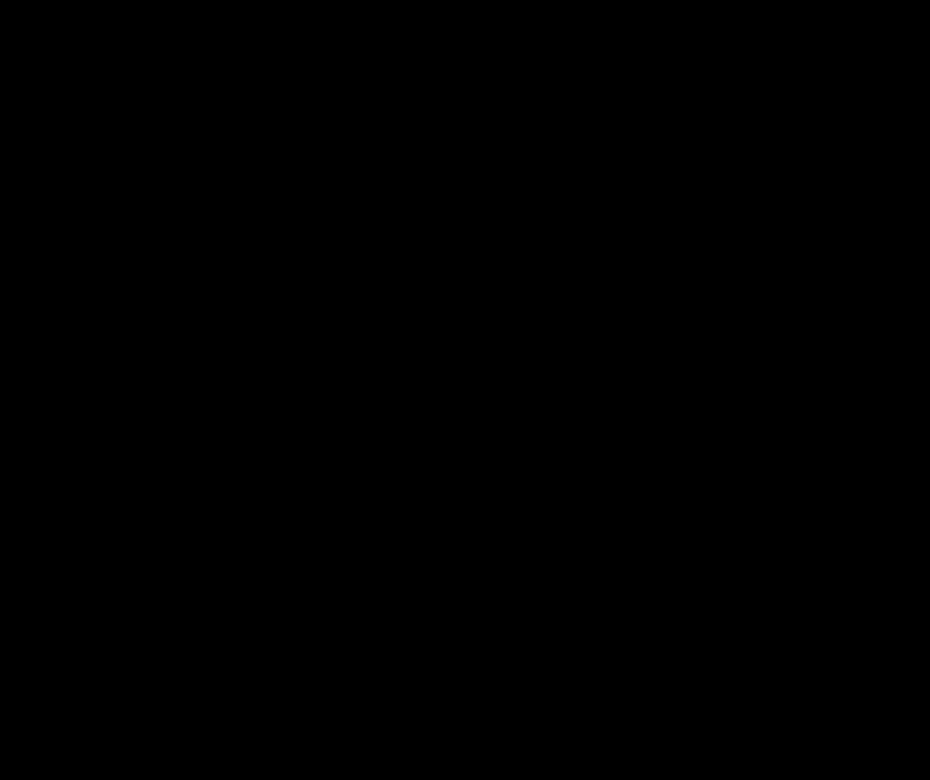
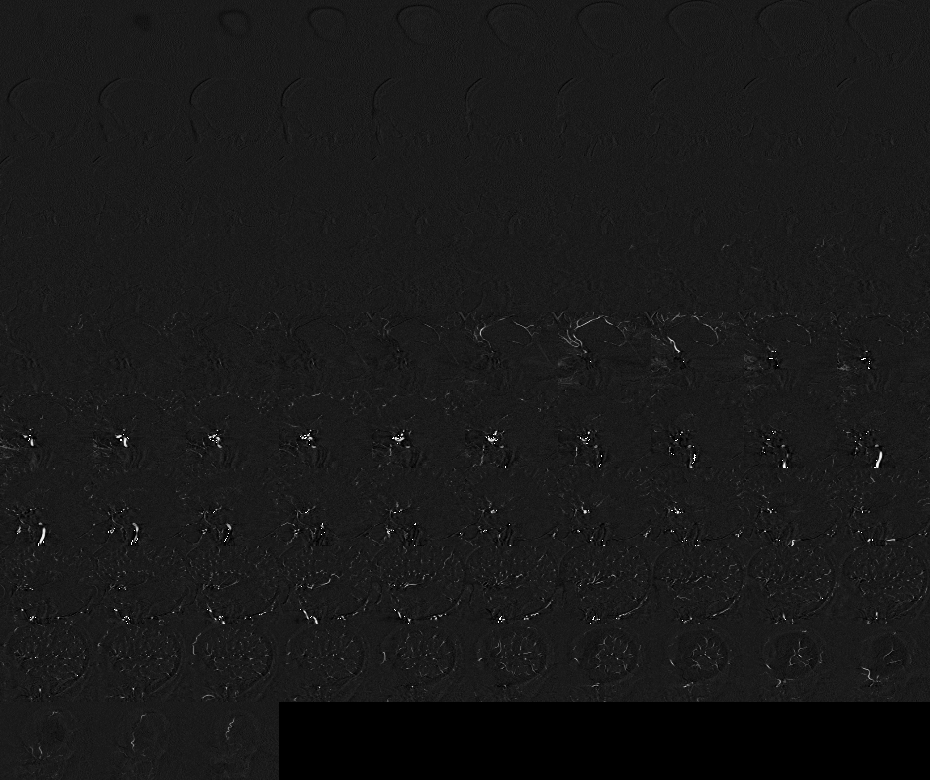

In [22]:
idx = 0
nip.view_img(
    nib.Nifti1Image(mri_imgs_train[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

0.0 1.0 None None


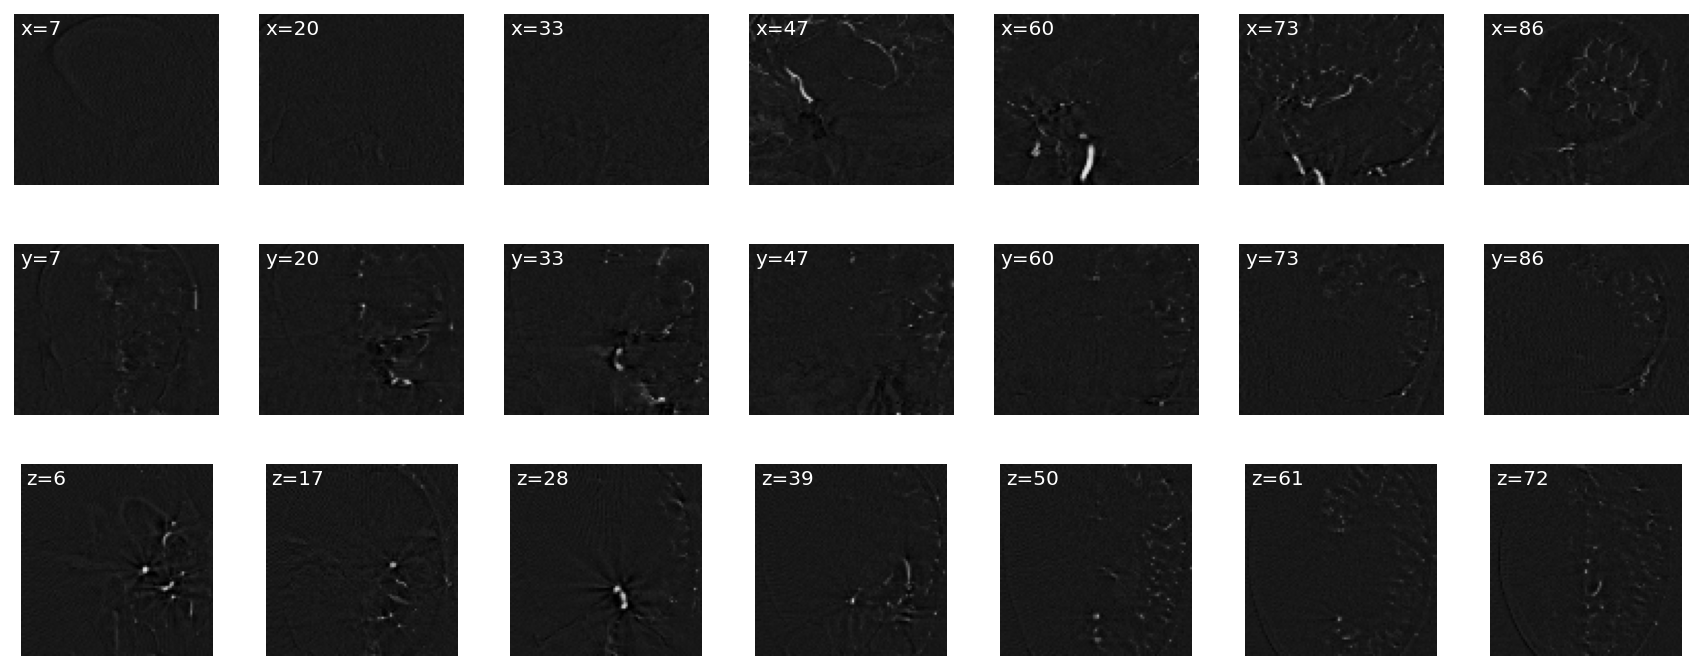

In [24]:
evaluation.plot_slices(mri_imgs_train[0])

## Train Model
Implementation, configuration, and evaluation of the experiment.

### Train Deep Model 3D data

In [29]:
artifacts = {
    "train_data": (mri_imgs_train, labels_train),
    "val_data": (mri_imgs_val, labels_val),
    "test_data": (mri_imgs_test, labels_test)
}

# Define parameter configuration for experiment run
params = {
    "batch_size": 3,
    "epochs": 10,
    "learning_rate": 5.0e-3, # 3e-04, 1.0E-5
    "es_patience": None, # None = deactivate early stopping
    "weight_decay": 0.001, # 1e-3
    "model_name": 'SimpleCNN3D',
    "optimizer_momentum": 0.9,
    "optimizer":'Adam',
    "criterion": "CrossEntropyLoss", 
    "criterion_weights": [1.0, 100.0], # [1.75, 1.0],
    "sampler": None,   #'ImbalancedDatasetSampler2',
    "shuffle_train_set": True,
    "scheduler": "ReduceLROnPlateau", # "ReduceLROnPlateau",
    "save_models": False,
    "debug": True,
}

params.update(dataset_params)
params.update(preprocessing_params)

# data augmentation

In [30]:
# Run experiment and sync all metadata
exp = env.create_experiment(
    params["prediction"] + "-pytorch-" + params["model_name"],
    comet_ml.Experiment(
        env.cached_data["comet_key"],
        project_name=env.project + "-" + params["prediction"],
        disabled=params["debug"],
    ),
)
exp.run(training.train_pytorch_model, params, artifacts)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


[INFO] Experiment vessel-pytorch-SimpleCNN3D is initialized.
[INFO] Running experiment: 2021-06-13-11-51-28_vessel-pytorch-simplecnn3d
Number of Classes 2
Selected model: SimpleCNN3D
[INFO] Train dataset loaded. Length: 5
[INFO] Validation dataset loaded. Length: 1
[INFO] Engine run starting with max_epochs=10.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Learning rate: 0.005
[INFO] Engine run complete. Time taken: 00:00:01
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.53 Avg loss: 0.66
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Learning rate: 0.005
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.53 Avg loss: 0.66
[INFO] Epoch[1] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Learning rate: 0.005
[INFO] Engine run complete. Tim

ValueError: not enough values to unpack (expected 2, got 0)

## Evaluate Model

Do evaluation, e.g. visualizations  

In [ ]:
from aneurysm_utils.utils.pytorch_utils import predict

In [ ]:
model = exp.artifacts["model"]

In [ ]:
predictions = predict(model, mri_imgs_val,apply_softmax=False )

In [ ]:

idx = 0
nip.view_img(
    nib.Nifti1Image(predictions[0][0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [ ]:
idx = 0
nip.view_img(
    nib.Nifti1Image(labels_val[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)